In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import os, sys
import time, glob
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.layers import *
from keras.models import Model
from keras.callbacks import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from LaneDataGenerator import LaneDataGenerator

%matplotlib inline

## DataGenerator

In [9]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 40, 120, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

data_gen = LaneDataGenerator(images_folder='./dataset/images',
                             labels_folder='./dataset/labels',
                             batch_size=4,
                             input_shape=INPUT_SHAPE)

### visualize data

0.21052590000000002


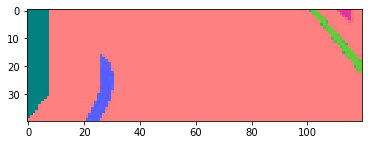

In [10]:
# data generator return image<YUV[0., 255.]>
# and steering_angle<normalized[-1., 1.]>
vis_im, vis_steering = data_gen[0]
plt.imshow(vis_im[0].astype(np.uint8))
print(vis_steering[0])

In [11]:
len(data_gen)

5

## Create model

In [12]:
K.clear_session()

net_in = Input(shape = INPUT_SHAPE)
x = Lambda(lambda x: x/127.5 - 1.0)(net_in)
x = Conv2D(24, (5, 5), strides=(2, 2),padding="same", activation='elu')(x)  
x = Conv2D(36, (5, 5), strides=(2, 2),padding="same", activation='elu')(x)
x = Conv2D(48, (5, 5), strides=(2, 2),padding="same", activation='elu')(x)
x = Conv2D(64, (3, 3), padding="same",activation='elu')(x)   
x = Conv2D(64, (3, 3), padding="same",activation='elu')(x)

x = Dropout(0.3)(x)

x = Flatten()(x)

x = Dense(100, activation='elu')(x)
x = Dense(50, activation='elu')(x)
x = Dense(10, activation='elu')(x) 

net_out = Dense(1, name='net_out')(x)

model = Model(inputs=net_in, outputs=net_out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 120, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 40, 120, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 60, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 30, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 15, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 15, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 15, 64)         3692

## Train

In [13]:
model.compile(loss='mse', optimizer=Adam(lr=0.001))

In [14]:
filepath = ("./checkpoints/LaneDetector{epoch:03d}-{loss:.3f}.h5")
checkpoint = ModelCheckpoint(filepath, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.5, verbose=1, mode='min')

history = model.fit_generator(
        data_gen, 
        steps_per_epoch=10,
        epochs=1000,        
        initial_epoch=0,
        callbacks=[checkpoint, reduce_lr],
        workers=2, use_multiprocessing=False)

Epoch 1/1000


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
	 [[Mean/_179]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
0 successful operations.
0 derived errors ignored.

## Convert to .tflite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model_file('checkpoints/LaneDetector277-0.002.h5') 
model = converter.convert()
file = open( 'model.tflite' , 'wb' ) 
file.write( model )
file.close()